In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from itertools import combinations


In [2]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train = train.sort_values(['STOCK', 'DATE']).reset_index()
test  = test.sort_values(['STOCK', 'DATE']).reset_index()

## Dataset Imputation

Based on our findings during the EDA, we are now imputing missing values.

In [3]:
ret_features = [f'RET_{day}' for day in range(1,6)]
ret_to_drop = train[(train[ret_features].isna().sum(axis=1)/(train[ret_features].shape[1]) >= 1)][ret_features]

train.drop(index=ret_to_drop.index, inplace=True) # Drop all rows with no observed returns over the past 5 days

In [4]:
for column in [f'VOLUME_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [5]:
for column in [f'RET_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

# Feature Engineering

In [6]:
new_features = []

New features is motivated by EDA, financial theories, or empirical evidence.
I included: 
- Daily sector-level return at each lags (1, 2, 3, 4): because comparing with sector mean helps evaluating the performance. 
 - Weekly mean and sd of return and volume: indvd lags beyond 5 are noisy but blocks like 1-5 and 6-10 can still carry info about the medium term -> instead of giving 20 noisy daily lags, give 4 recent weeks' summary per stock

Regroup the features by SECTOR/DATE and compute avg daily mean of lags 1 to 4. Beyond lags 4, I'll use aggregates because as there are fewer raw signals there

In [7]:
# Conditional aggregated features
shifts = [1,2,3,4] 
statistics = ['mean']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

Under the assumption, that 1 week = 5 days, compute the weekly average and standard deviation of the past four weeks. 

In [ ]:
weeks = 4
statistics = ['mean', 'std']
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_STOCK_WEEK_{week+1}'
                new_features.append(name)
                for data in [train, test]:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs() # to measure magnitude,as VOLUME has signs/direction already
                        else:
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

Next, I implement the sector-relative volume ratio (stock's volume compared/normalized to its weekly sector). 

In [9]:
shifts = [1,2,3,4] 
statistics = ['sum']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

Same but now for the return. As about 86–90% of variance is between sectors, we normalise by the sector sum to remove the big sector factor and keep idiosyncratic relative return.

In [10]:
shifts = [1,2,3,4] 
statistics = ['sum'] 
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

Ret and volume 10 show some relatively higher correlation with target, so I experiment with 10-day momentum features.

Here is residual return momentum. We do so by calculating the average return over day D-1,...,D-10 and subtract the return of day D to obtain an idea where our stock might go. The residual return momentum reflects recent performance trends in the sector. 

In [11]:
weeks = [2]
targets = ['RET', 'VOLUME']

for target in targets:
    for week in weeks: 
        window_size = 5*week
        name = f'{target}_{window_size}_day_momentum'
        new_features.append(name)
        for data in [train, test]:
            _data = data.copy()
            rolling_mean_target = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
            target_1_mean = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()
            target_1_mean_aligned, rolling_mean_target_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='SECTOR')
            target_momentum = target_1_mean_aligned.sub(rolling_mean_target_aligned.mean(axis=1), axis=0)
            target_momentum.rename(columns={f'{target}_1': name},inplace=True)
            placeholder = _data.join(target_momentum, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

Here we compute the standard deviation of the averages to measure the volatility of sector's daily avg return over the week 

In [12]:
weeks = [2]
targets = ['RET', 'VOLUME']

for week in weeks: 
    window_size = 5*week
    for target in targets: 
        name = f'{window_size}_day_mean_{target}_vola'
        new_features.append(name)
        for data in [train, test]:
            rolling_std_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
            placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

We are now going to add the sector-level relative strength index (RSI) sector. In text book, RSI measures the change of price movements.

In [13]:
targets = ["RET"]
window_size = 20
name = f"RSI_SECTOR_DATE_{window_size}"
new_features.append(name)

for target in targets:
    for data in [train, test]:
        _data = data.copy()
        avg_gain_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
        avg_loss_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
        rs_sector_day = avg_gain_sector_day/avg_loss_sector_day
        rsi_sector_date = 100 - 100/(1+rs_sector_day)
        placeholder = _data.join(rsi_sector_date.to_frame(name), on=['SECTOR', 'DATE'], how='left')
        data[name] = placeholder[name]

RSI looks at the avg size of gains and losses over 20 lags. We'd like to understand as well how many stocks go up and down each day in a sector. We then add an aggregated advance-decline line indicator conditioned on sector. ADLsum​=∑​Net Advances_i (signal of overall market trends)

In [14]:
window_size = 5
name = 'Sum_ADL'
new_features.append(name)
for data in [train, test]:
    _data = data.copy()
    sum_adl = ((_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
    placeholder = _data.join(sum_adl.to_frame(name), on=['SECTOR', 'DATE'], how='left')
    data[name] = placeholder[name]

# Feature Selection

In [18]:
target = 'RET'

n_shifts_ret = 5  # To reduce noise from later shifts
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # features created above
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE,mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE,mean_RET_STOCK_WEEK_3_/total_RET_of_SECTOR_DATE,mean_RET_STOCK_WEEK_4_/total_RET_of_SECTOR_DATE,RET_10_day_momentum,VOLUME_10_day_momentum,10_day_mean_RET_vola,10_day_mean_VOLUME_vola,RSI_SECTOR_DATE_20,Sum_ADL
0,-0.005967,0.009031,0.008296,0.002638,0.012739,0.136699,-0.003109,0.015042,0.570881,0.746002,...,0.005523,0.021981,0.002407,0.018267,-0.002850,-0.029705,0.007561,0.048838,49.364457,292
1,0.001348,0.011100,0.012023,-0.016477,0.005654,-0.269520,-0.085622,-0.324746,-0.155429,-0.379779,...,0.041524,-0.009089,0.001913,-0.031775,0.000370,-0.065635,0.005089,0.201796,59.212854,44
2,-0.014405,0.003614,0.011156,0.000000,0.002700,0.192655,0.353804,-0.133228,-0.085529,0.001736,...,-0.008523,-0.000223,0.024546,0.004293,-0.018693,-0.081960,0.012265,0.116282,49.351113,-14
3,0.008938,0.002662,0.002490,0.014896,-0.002252,0.430916,0.175444,-0.083462,-0.352598,-0.130800,...,0.012921,-0.024078,-0.004283,-0.167389,-0.008145,0.053479,0.006282,0.116467,51.510651,98
4,-0.006523,-0.007632,0.004756,0.005466,-0.006111,-0.060371,-0.037806,-0.251701,-0.020684,-0.503069,...,-0.012370,0.003576,0.362947,0.038859,-0.010167,-0.083851,0.006679,0.112301,54.197333,13


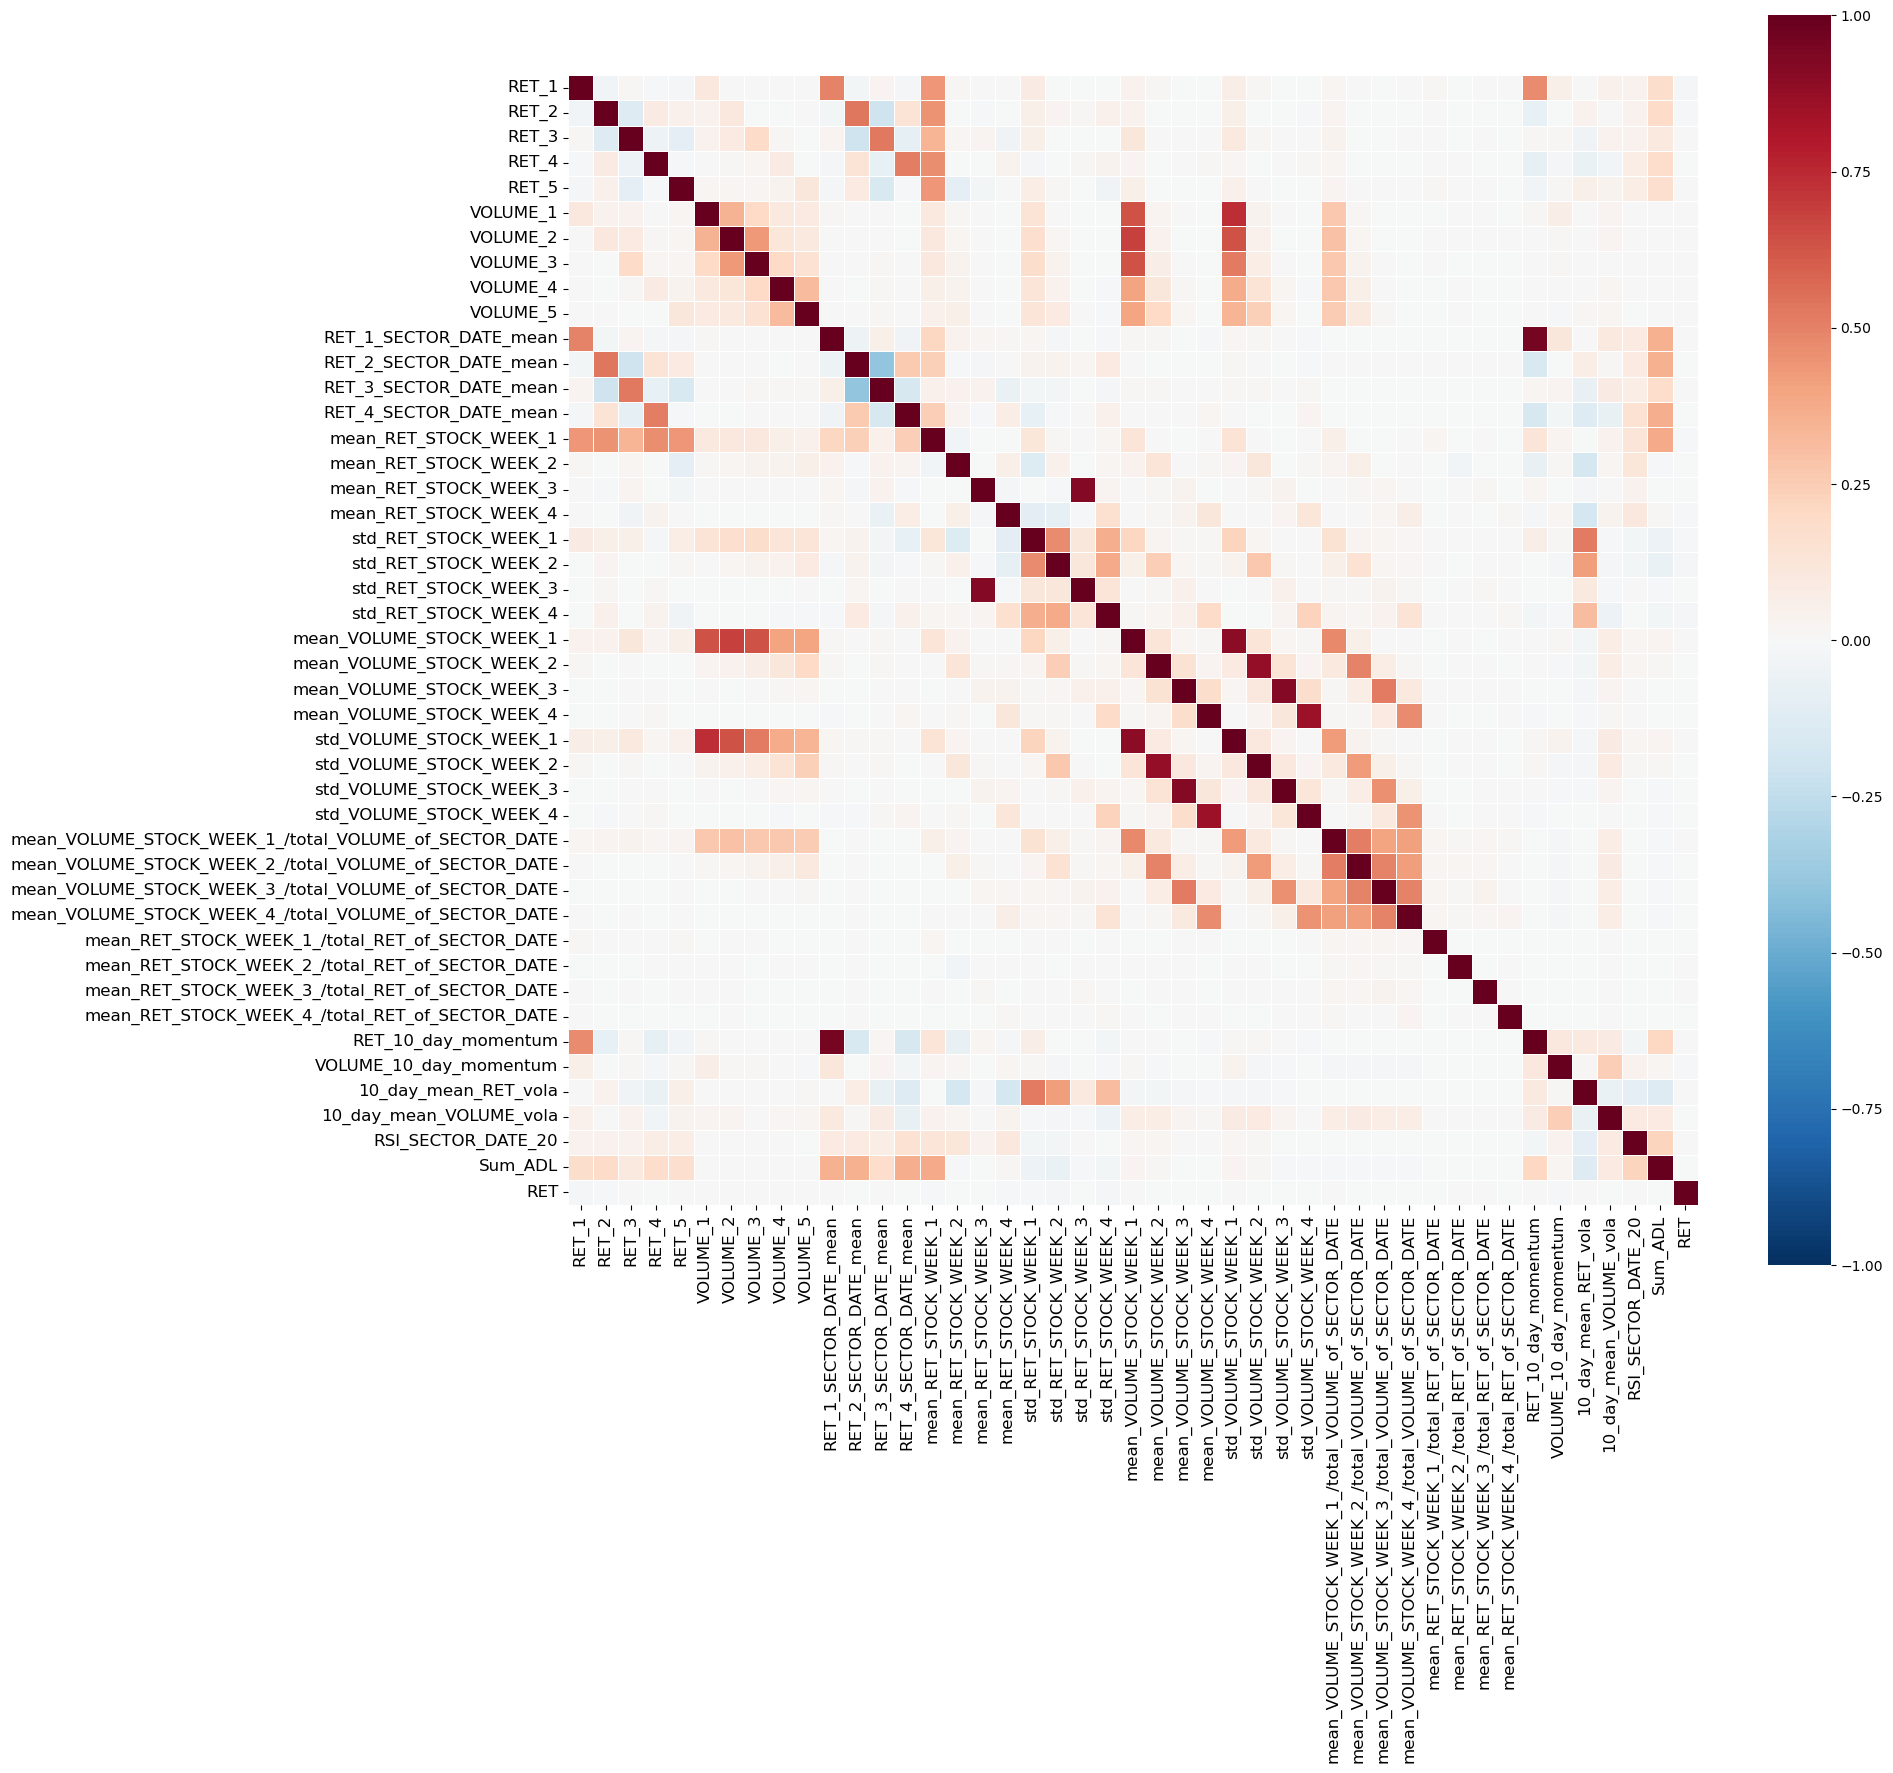

In [17]:
corr_features = features + ['RET']
corr_matrix = train[corr_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Model Selection

From experiments in earlier notebook versions, RF performed the best across different feature ranges, but it took more time to run. So I used the LGBM implementation of RF to quickly test and identify new promising features.

In [ ]:
X_train = train[features]
y_train = train[target]

parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    'feature_fraction': np.log(X_train.shape[0])/X_train.shape[0], # LGBM equivalent of sklearn RF's default max_features = sqrt(n_features)
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.01%
Fold 2 - Accuracy: 51.22%
Fold 3 - Accuracy: 52.95%
Fold 4 - Accuracy: 52.04%
Accuracy: 51.80% [51.04 ; 52.57] (+- 0.76)


Modest but consistent — well above 50% on a binary classification task with very weak signal (recall corr ≈ 0.01–0.02). The low std (0.76%) confirms the model generalises across folds without overfitting.

<Axes: >

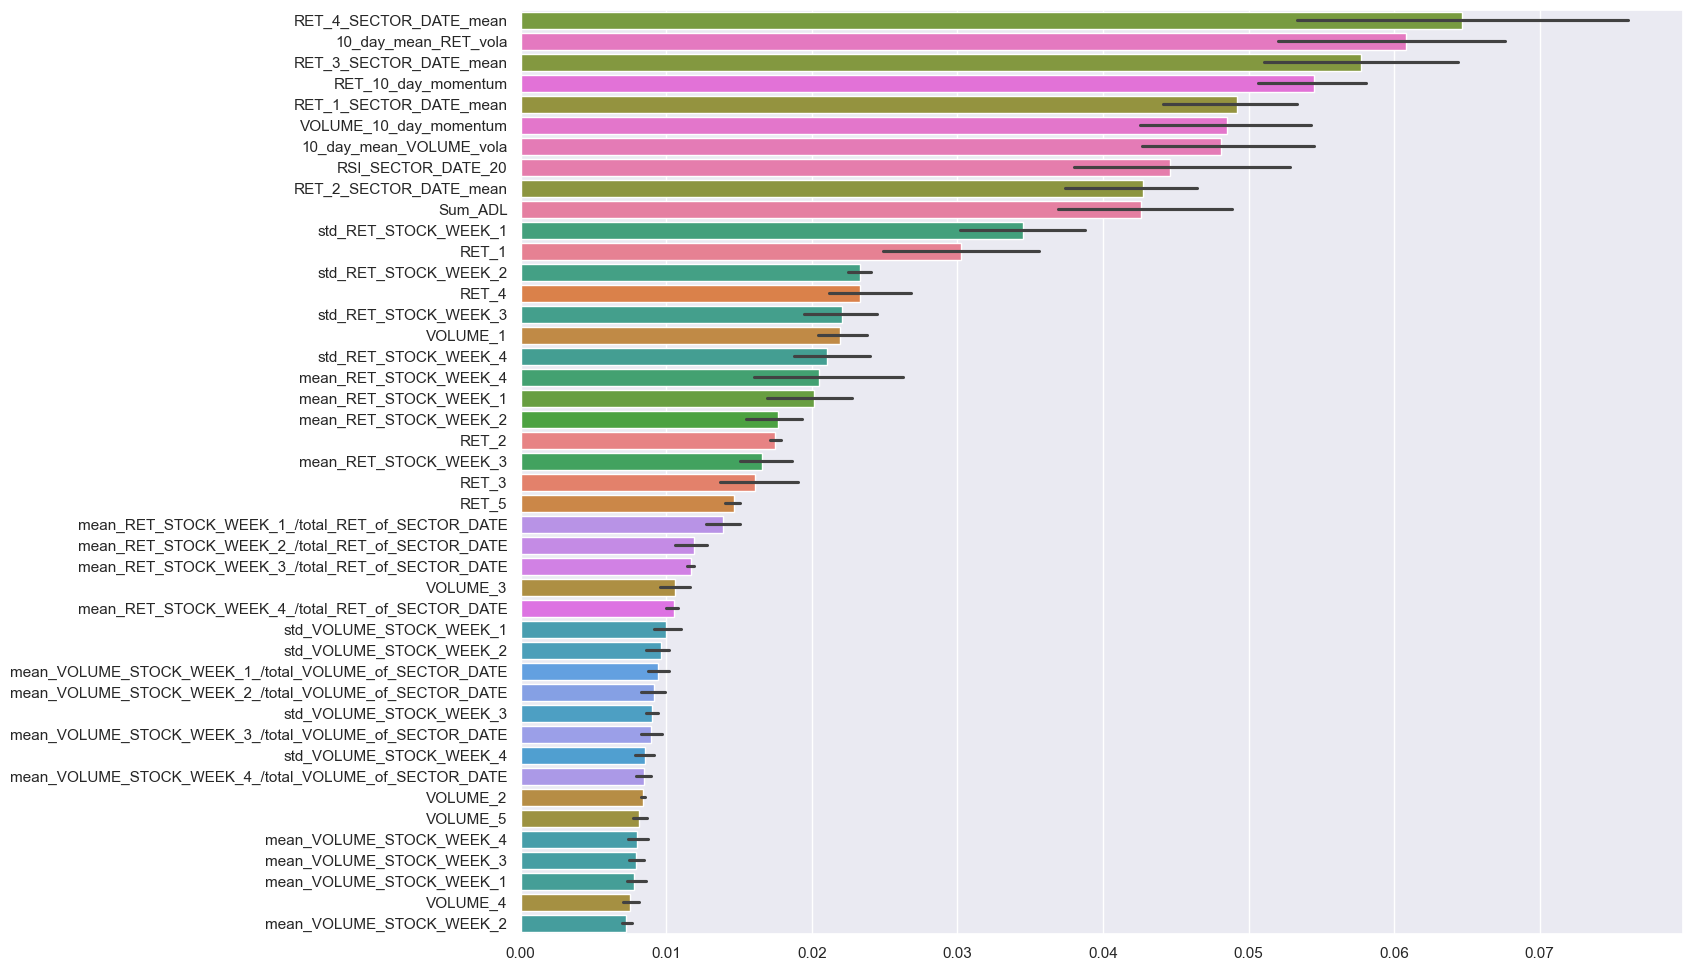

In [21]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

Sector context proves most predictive. Volatility and medium-term momentum are also confirmed as strong signals. RSI and ADL also made it into top 10.

# Prediction

In [23]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

mean_importance = feature_importances.mean()
best_features = mean_importance[mean_importance > 0.005].index.tolist()
print(len(best_features), "features kept")

target = 'RET'
y_train = train[target]
# X_train = train[features]
# X_test = test[features]
X_train = train[best_features]   
X_test  = test[best_features]    

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

# Use diferend decision rules and compare their accuracy
sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print('median', accuracy_score(y_pred_train,y_train))

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.mean()).values
print('mean', accuracy_score(y_pred_train,y_train))

print('built-in', accuracy_score(model.predict(X_train),y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

44 features kept
median 0.5817230670199045
mean 0.5813075402496524
built-in 0.5749905725862818


Per-date median threshold gives the best training score, so we use that for best submission.

Best submission: 

In [ ]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
# X_train = train[features]
# X_test = test[features]
X_train = train[best_features]   
X_test  = test[best_features]    

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

0.5817230670199045


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

In [24]:
submission.value_counts(normalize=True)

RET
False    0.500068
True     0.499932
Name: proportion, dtype: float64

Corresponding feature importances:

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

<Axes: >

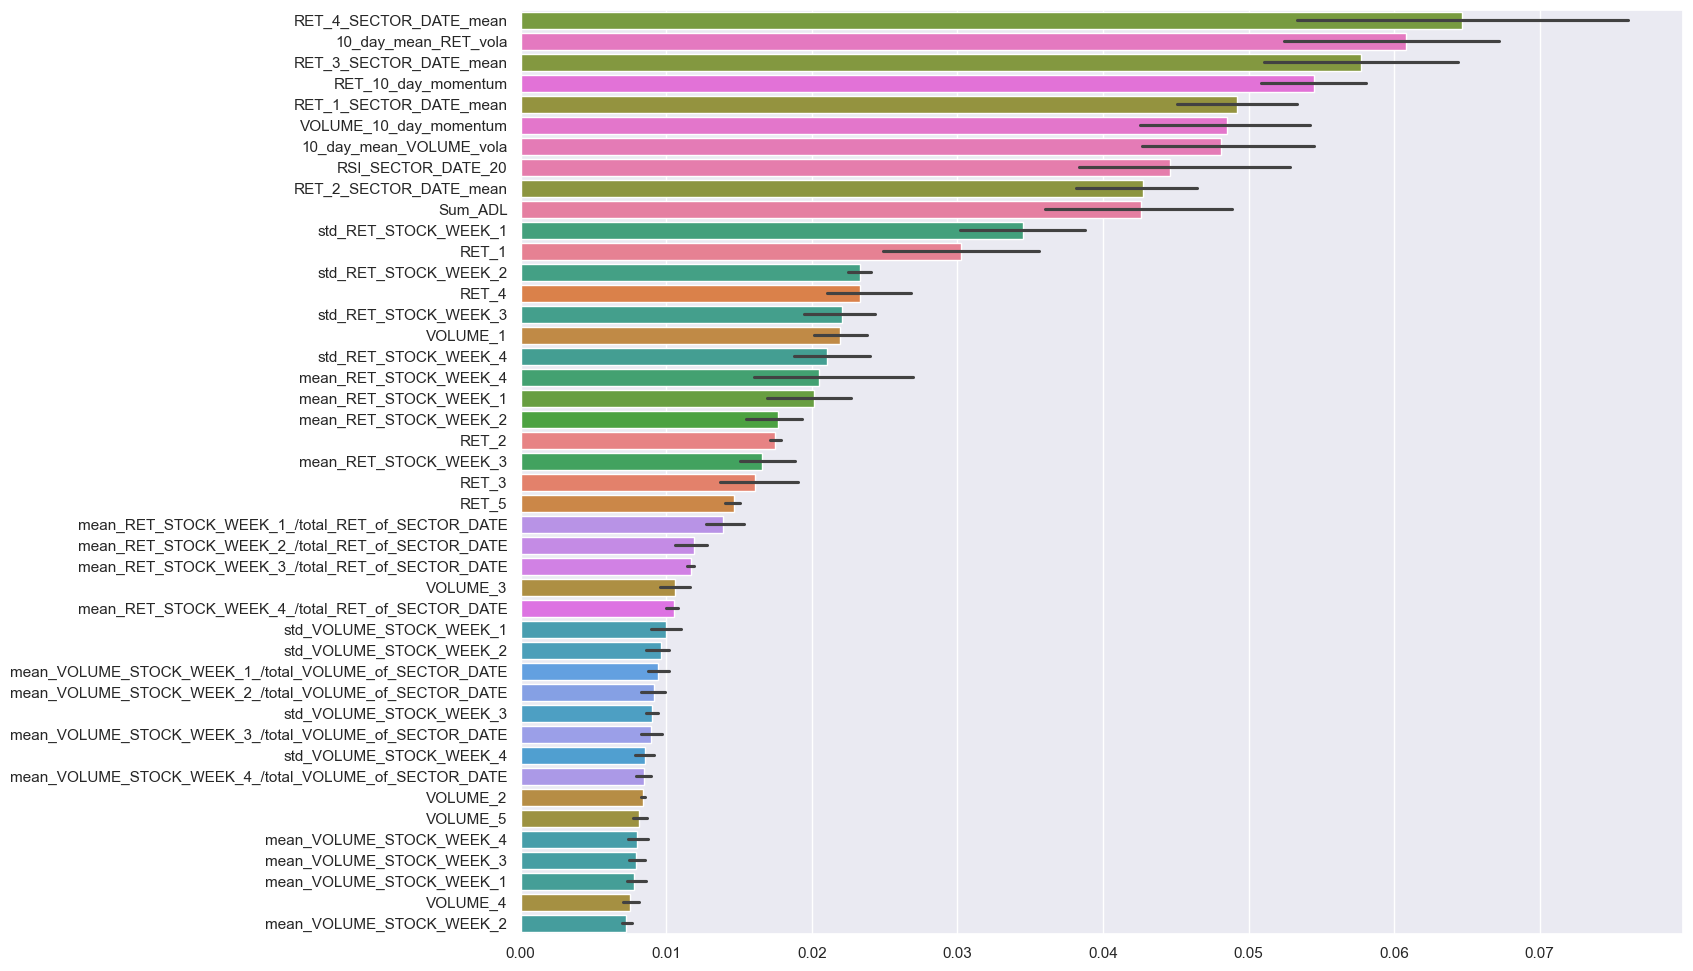

In [25]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

## Experiments 

I have done various feature experiments with stock-level signals, but many only add noise.

In [19]:
def create_enhanced_cross_sectional_features(df):
    df_new = df.copy()
    
    if 'DATE' not in df_new.columns:
        return df_new
    
    # 1. PERCENTILE RANKS 
    for col in [f'RET_{i}' for i in range(1, 21)]:
        if col in df_new.columns:
            # Date-level rank
            df_new[f'{col}_pctrank'] = df_new.groupby('DATE')[col].rank(pct=True)
    
    # 2. SECTOR-RELATIVE RANKS
    if 'SECTOR' in df_new.columns:
        for col in [f'RET_{i}' for i in range(1, 11)]:
            if col in df_new.columns:
                df_new[f'{col}_sector_pctrank'] = df_new.groupby(['DATE', 'SECTOR'])[col].rank(pct=True)
    
    # 3. VOLUME RANKS (liquidity matters!)
    for col in [f'VOLUME_{i}' for i in range(1, 11) if f'VOLUME_{i}' in df_new.columns]:
        df_new[f'{col}_pctrank'] = df_new.groupby('DATE')[col].rank(pct=True)
    
    # 4. CROSS-SECTIONAL Z-SCORES (alternative to ranks)
    for col in [f'RET_{i}' for i in range(1, 11)]:
        if col in df_new.columns:
            df_new[f'{col}_cs_zscore'] = df_new.groupby('DATE')[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 5. RELATIVE TO SECTOR MEDIAN (deviation from peers)
    if 'SECTOR' in df_new.columns:
        for col in [f'RET_{i}' for i in range(1, 6)]:
            if col in df_new.columns:
                sector_median = df_new.groupby(['DATE', 'SECTOR'])[col].transform('median')
                df_new[f'{col}_vs_sector_med'] = df_new[col] - sector_median
    
    # 6. COMPOSITE MOMENTUM RANKS
    df_new['momentum_1_5'] = df_new[[f'RET_{i}' for i in range(1, 6)]].mean(axis=1)
    df_new['momentum_1_5_pctrank'] = df_new.groupby('DATE')['momentum_1_5'].rank(pct=True)
    
    df_new['momentum_6_20'] = df_new[[f'RET_{i}' for i in range(6, 21)]].mean(axis=1)
    df_new['momentum_6_20_pctrank'] = df_new.groupby('DATE')['momentum_6_20'].rank(pct=True)
    
    # 7. VOLATILITY RANKS (risk-adjusted)
    df_new['vol_5d'] = df_new[[f'RET_{i}' for i in range(1, 6)]].std(axis=1)
    df_new['vol_5d_pctrank'] = df_new.groupby('DATE')['vol_5d'].rank(pct=True)
    
    # 8. RETURN-TO-VOLATILITY RATIO (Sharpe-like)
    df_new['ret_vol_ratio'] = df_new['momentum_1_5'] / (df_new['vol_5d'] + 1e-8)
    df_new['ret_vol_ratio_pctrank'] = df_new.groupby('DATE')['ret_vol_ratio'].rank(pct=True)
    
    return df_new

I have also tried different feature strategies, choosing the best features of different categories, but what worked best seem to use raw of more recent lags and aggregates of later lags. 

I have also tried out different hyper-parameter tuning for XGBoost, LGBM, and RF in earlier notebook versions like Optuna, GridSearch CV etc. and used the best one in this one without re-training, as it takes a lot of time and memory. 